# GradCAM example for 3 models

In [1]:
from pathlib import Path

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent.parent 
print(proj_path)

C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding


In [2]:
import pandas as pd
import numpy as np
import itertools
import torch
from torch.utils.data import DataLoader
import pickle
import re
from nltk.metrics import distance

from deep_nlp.cnncharclassifier import CNNCharClassifier, charToTensor
from src.deep_nlp.embed_cnn.embcnnmodel_gradcam import classifier3F
from deep_nlp.bilstm_cnn.bilstmcnn_gradcam import BilstmCnn
from deep_nlp.grad_cam.utils.letter import rebuild_text, prepare_heatmap, LetterToToken
from deep_nlp.grad_cam.plot import plot_bar_heatmap, plot_text_and_heatmap

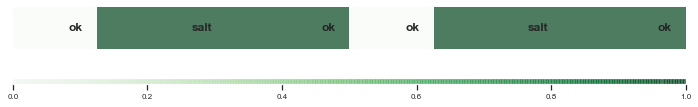

In [4]:
plot_text_and_heatmap(text= ["ok", "salt", "ok"]*2
                      , heatmap= np.array([0, 1, 2]*2)
                      , figsize= (10, 3)
                      , fontsize_text= "medium"
                      , cmap= "Greens" #if type_map == "max" else "PiYG"
                      , word_or_letter= "word")

## CNN Character level

In [ ]:
# params
cnn_sequence_len= 1014
cnn_feature_num= 87
cnn_feature_size= 256
cnn_kernel_one= 7
cnn_kernel_two= 3
cnn_stride_one= 1
cnn_stride_two= 3
cnn_output_linear= 1024
cnn_num_class= 2
cnn_dropout= 0.5
cnn_cuda_allow= True

In [ ]:
# Load model
model_path_saved= "data/06_models/cnn_char_classifier/cnn_char_model/cnn_char_model.pt"

with open(str(proj_path)+ "\\" + model_path_saved, 'rb') as f:
    model_saved= pickle.load(f)

In [ ]:
# Load test data
data_df= pd.read_csv(str(proj_path)+ "\\" + "data/01_raw/allocine_test.csv")

test_data= charToTensor(data_df= data_df, sentence_max_size= cnn_sequence_len)

In [ ]:
# Initialisation
parameters = {"sequence_len": cnn_sequence_len, "feature_num": cnn_feature_num
    , "feature_size": cnn_feature_size, "kernel_one": cnn_kernel_one
    , "kernel_two": cnn_kernel_two, "stride_one": cnn_stride_one
    , "stride_two": cnn_stride_two, "output_linear": cnn_output_linear
    , "num_class": cnn_num_class, "dropout": cnn_dropout}

In [ ]:
model = CNNCharClassifier(**parameters)

if cnn_cuda_allow:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

model.load_state_dict(model_saved)

state_dict= model.module.state_dict() # delete module to allow cpu loading

cpu_model= CNNCharClassifier(**parameters).cpu()
cpu_model.load_state_dict(state_dict)

cpu_model.eval()

In [ ]:
model_cpu_dict= cpu_model.state_dict()

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
save_object(model_cpu_dict, "models/cnn_char_cpu.pt")

In [ ]:
# Display results
def cnn_char_gradcam(index, threshold= None,**kwargs):
    """
    Display gradcam text with knowing the index text position
    
    -------
    
    kwargs:
        - model
        - loader : type charToTensor
        - cnn_sequence_len
        - params_graphics
    """
    loader= kwargs["loader"]
    model= kwargs["model"]
    type_map= kwargs["type_map"]
    num_class= kwargs["num_class"] 
    figsize= kwargs["figsize"]
    
    text_sentence, _= loader[index]
    text_sentence= torch.unsqueeze(text_sentence, 0)
    
    model.eval()
    output= model(text_sentence)
    print("Proba class 1 : {}".format(torch.exp(output)[:, 1].data.numpy()[0]))
    
    heatmap_= model.get_heatmap(text= text_sentence
                                    , num_class= num_class
                                    , dim= [0, 2]
                                    , type_map= type_map)
    
    # get the unique element
    heatmap_values= heatmap_[-1]
    
    # CNNChar rebuilt from input the text
    alphabet= loader.get_alphabet()+" "
    rebuild_sentence= rebuild_text(text= text_sentence
                                     , alphabet= alphabet
                                     , space_index= len(alphabet) - 1 #83 # ajout de +4 si pas fait
                                     , sequence_len= cnn_sequence_len)
    
    # Resize heatmap Brutal method
    heatmap_match_sentence_size_invert= prepare_heatmap(heatmap= heatmap_values
                                                    , text= rebuild_sentence)
    
    ## Transform character level to token one
    letter_to_token= LetterToToken(text= rebuild_sentence
                                   , heatmap= heatmap_match_sentence_size_invert)

    results_dict= letter_to_token.transform_letter_to_token(type= "tanh")
    tokens= results_dict["tokens"]
    heatmap_test= results_dict["heatmap"]
    
    if threshold: # if inquired
        condition= np.where(np.abs(heatmap_test) < threshold)[0] # if under, get index
        heatmap_test[condition]= 0 # replace undervalues by 0
    
    plot_text_and_heatmap(text= tokens
                      , heatmap= heatmap_test
                      , figsize= figsize
                      , fontsize_text= "small"
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , word_or_letter= "word")
    return heatmap_test

In [ ]:
# %matplotlib
index= 14359 - 1
num_class= 0
figsize= (10, 4)
# cnn_char_gradcam(index, model= cpu_model, loader= test_data, type_map= "normalized_2"
#                  , num_class= num_class, figsize= figsize)
cnn_char_gradcam(index, model= cpu_model, loader= test_data, type_map= "max"
                 , num_class= num_class, figsize= figsize)

## Embedding vanilla

In [ ]:
test_iterator_cnn_embed_path= "data/02_intermediate/test_iterator_cnn_embed.pkl"

with open(str(proj_path)+ "\\" + test_iterator_cnn_embed_path, 'rb') as f:
    test_iterator_cnn_embed= pickle.load(f)
    
print(type(test_iterator_cnn_embed))

In [ ]:
# Embedding model
embed_for_torch_path= "data/04_feature/w2v_torch.pkl"

with open(str(proj_path)+ "\\" + embed_for_torch_path, 'rb') as f:
    embed_for_torch= pickle.load(f)
    
print(type(embed_for_torch))

In [ ]:
word_ind_dict_path= "data/04_feature/voc.pkl"

with open(str(proj_path)+ "\\" + word_ind_dict_path, 'rb') as f:
    word_ind_dict= pickle.load(f)
    
print(type(word_ind_dict))

In [ ]:
# Params
# params_models = {"wv": embed_for_torch,"no_words": 67,"embedding_dim":200, "nb_filter":200
#                  , "height_filter":tuple([1, 2, 3, 4, 5]), "output_dim":2, "dropout":0.8, "padded":True}

params_models = {"wv": embed_for_torch,"no_words": 67,"embedding_dim":200, "nb_filter":600
                 , "height_filter":tuple([1, 2]), "output_dim":2, "dropout":0.6, "padded":True}

In [ ]:
# Model dict
embed_cnn_model_for_save_path= "data/06_models/embed_cnn/embed_cnn_classifier/embed_cnn.pt"

with open(str(proj_path)+ "\\" + embed_cnn_model_for_save_path, 'rb') as f:
    embed_cnn_model_for_save= pickle.load(f)
    
print(type(embed_cnn_model_for_save))

In [ ]:
model_embed = classifier3F(**params_models)

model_embed.load_state_dict(embed_cnn_model_for_save)
model_embed= model_embed.cpu()
model_embed.eval()

In [ ]:
save_object(model_embed.state_dict(), "models/embed_cnn_cpu.pt")

In [ ]:
!python -m spacy download fr_core_news_md
import spacy
nlp= spacy.load("fr_core_news_sm",  disable=["tagger", "parser","ner"])

In [ ]:
# display
import unicodedata

def split_sentence(token: str, pattern_token_split= r'[\s\.\,\:\;\(\)\[\]\&\!\?\/\\]+'):
    return re.split(pattern_token_split, token)

def clean_tokens(token: str, pattern= r'[\s\.\,\:\;\"\'\(\)\[\]\&\!\?\/\\]+'):
    cleaned_token= re.sub(pattern, "", token)
    return ''.join(c for c in unicodedata.normalize('NFD', cleaned_token)
                        if unicodedata.category(c) != 'Mn').lower()

def fast_lemm_token(token):
    if token != "":
        return [i.lemma_ for i in nlp(clean_tokens(token))][0]
    else:
        return ""
    
def compute_index_max_distance_jako(selected_word, tokenized_sentence, safe_threshold= 0.2
                                    , sentence_length_wihout_clean= 120):
    """
    jaro_winkler_sim = jaro_sim + ( l * p * (1 - jaro_sim) )
    jaro_sim = 0 if m = 0 else 1/3 * (m/|s_1| + m/s_2 + (m-t)/m)

    where:
        - |s_i| is the length of string s_i
        - m is the no. of matching characters
        - t is the half no. of possible transpositions.
    """
    stock_all_word_dist= []
    last_up= 0
    tokenized_sentence= tokenized_sentence[:sentence_length_wihout_clean] # sentence length, to ensure it is not looking for
    # not implemented words (more than 67 because 67 was after cleaning, stop word and lemme)
    for input_word in selected_word:
        stock_input_word_dist= []

        d= [distance.jaro_winkler_similarity(fast_lemm_token(input_word), fast_lemm_token(input_initial))
           for input_initial in tokenized_sentence]
        # safety threshold, if under stop the processus for the token
        if max(d) <= safe_threshold:
            continue
        else: 
            tokenized_sentence= tokenized_sentence[np.argmax(d):]
            last_up= np.argmax(d) + last_up # we cut the tokenized list, so we remember where was the
        # last highest value in index
        stock_all_word_dist.append(last_up)
    return np.array(stock_all_word_dist)


def embed_gradcam(index, heatmap_index, index_nothing= None, model_type= None
                  , threshold= None, figsize_second= (10, 4), fontsize_text_second= "small" 
                  , threshold_second= 10, **kwargs):
    """
    Display gradcam text with knowing the index text position
    
    -------
    
    kwargs:
        - model
        - loader : type charToTensor
        - cnn_sequence_len
        - params_graphics
    """
    data_loader= kwargs["data_loader"]
    model= kwargs["model"]
    type_map= kwargs["type_map"]
    num_class= kwargs["num_class"] 
    figsize= kwargs["figsize"]
    vocab= kwargs["vocab"]
    initial_review= kwargs["initial_review"]
    
    text_sentence, _= next(itertools.islice(data_loader, index, None))
    if model_type == "bilstm":
        text_sentence= text_sentence.to(torch.int64)
    
    model.eval()
    output= torch.exp(model(text_sentence))
    print("Proba class 1 : {}".format(output[:, 1].data.numpy()[0]))
    
    heatmap_= model.get_heatmap(text= text_sentence
                                    , num_class= num_class
                                    , dim= [0, 2]
                                    , type_map= type_map)
    heatmap_values= heatmap_[heatmap_index]
    
    text_index = text_sentence.squeeze().numpy()
    vocab_reverse= {y:x for x,y in vocab.items()}
    word = np.array([vocab_reverse.get(index, "") for index in text_index])
    
    if index_nothing is None: # generate warning but its ok dude
        index_nothing = np.array([])
    selected_word_bool = np.in1d(text_index, index_nothing)
    # Get index of word we want
    selected_word_index = np.where((~selected_word_bool)|(word != ""))[0]
    # Select interesting words
    selected_word = word#word[selected_word_index]
    selected_heatmap_values= heatmap_values#[selected_word_index]
    
    if threshold: # if inquired
        condition= np.where(np.abs(selected_heatmap_values) < threshold)[0] # if under, get index
        selected_heatmap_values[condition]= 0 # replace undervalues by 0

    # Token heatmap
    plot_text_and_heatmap(text= selected_word.tolist()
                      , heatmap= selected_heatmap_values
                      , figsize= figsize
                      , fontsize_text= "small"
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , word_or_letter= "word")
#     print(selected_heatmap_values)
#     # Good token heatmap
#     tokenized_sentence= split_sentence(initial_review)
    
#     # Compute token distance between initial sentence token
#     stock_all_word_max_dist_id= compute_index_max_distance_jako(selected_word, tokenized_sentence)
# #     simi_tokens= np.argmax(stock_all_word_dist, axis= 1) 
#     based_heatmap= np.zeros(len(tokenized_sentence))

#     based_heatmap[stock_all_word_max_dist_id]= selected_heatmap_values[:stock_all_word_max_dist_id.shape[0]]
    
#     plot_text_and_heatmap(text= tokenized_sentence
#                       , heatmap= based_heatmap
#                       , figsize= figsize_second
#                       , fontsize_text= fontsize_text_second
#                       , cmap= "PiYG" if type_map == "max" else "Greens"
#                       , threshold= threshold_second
#                       , word_or_letter= "word")
    
    return selected_word, selected_heatmap_values

In [ ]:
index= 16237 - 1
num_class= 0
heatmap_index= -1
figsize= (10, 4)
index_nothing= np.array([155563, 155562])

data_review_test= pd.read_csv("../GradCam/all_model_prediction.csv")
initial_review_tt= data_review_test["review"].values

initial_review= initial_review_tt[index]

selected_word, selected_heatmap_values= embed_gradcam(index, heatmap_index= heatmap_index
                                                      , model= model_embed
                                                      , data_loader= test_iterator_cnn_embed
                                                      , type_map= "max", vocab= word_ind_dict
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))

## Bilstm

In [ ]:
#
embed_matrix_path= "data/02_intermediate/bilstm_cnn/embed_matrix.pkl"

with open(str(proj_path)+ "\\" + embed_matrix_path, 'rb') as f:
    embed_matrix= pickle.load(f)
    
print(type(embed_matrix))

In [ ]:
word_ind_dict_path_bilstm= "data/04_feature/voc_bilstm.pkl"

with open(str(proj_path)+ "\\" + word_ind_dict_path_bilstm, 'rb') as f:
    word_ind_dict_bilstm= pickle.load(f)
    
print(type(word_ind_dict_bilstm))

In [ ]:
#
test_batch_bilstm_path= "data/02_intermediate/test_iterator_cnn_bilstm.pkl"

with open(str(proj_path)+ "\\" + test_batch_bilstm_path, 'rb') as f:
    test_batch_bilstm= pickle.load(f)
    
print(type(test_batch_bilstm))#BiLSTM + CNN
num_epochs=  50
batch_size= 32
patience= 5
lr= 0.001
input_dim= 200
hidden_dim= 128
layer_dim= 2
feature_size= 256
output_dim= 2
kernel_size= 3
dropout_rate= 0.5
sentence_size= 67
padded= True

In [ ]:
#
bilstm_cnn_model_for_save_path= "data/06_models/bilstm_cnn/bilstm_cnn_classifier/bilstm_cnn.pt"

with open(str(proj_path)+ "\\" + bilstm_cnn_model_for_save_path, 'rb') as f:
    bilstm_cnn_model_for_save= pickle.load(f)
    
print(type(bilstm_cnn_model_for_save))

In [ ]:
model = BilstmCnn(embed_matrix, sentence_size, input_dim, hidden_dim
                  , layer_dim, output_dim, feature_size, kernel_size, dropout_rate, padded)

if cnn_cuda_allow:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

model.load_state_dict(bilstm_cnn_model_for_save)

state_dict= model.module.state_dict() 

cpu_bilstm_model= BilstmCnn(embed_matrix, sentence_size, input_dim, hidden_dim
                  , layer_dim, output_dim, feature_size, kernel_size, dropout_rate, padded).cpu()

cpu_bilstm_model.load_state_dict(state_dict)
cpu_bilstm_model

In [ ]:
save_object(cpu_bilstm_model.state_dict(), "models/bilstm_cnn_cpu.pt")

In [ ]:
index= 1- 1
num_class= 0
figsize= (10, 4)
index_nothing= np.array([144213])

data_review_test= pd.read_csv("../GradCam/all_model_prediction.csv")
initial_review_tt= data_review_test["review"].values

initial_review= initial_review_tt[index]

selected_word, selected_heatmap_values= embed_gradcam(index, heatmap_index= -1, model_type= "bilstm"
                                                      , model= cpu_bilstm_model
                                                      , data_loader= test_batch_bilstm
                                                      , type_map= "max"
                                                      , vocab= word_ind_dict_bilstm
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))
selected_heatmap_values

## Print all local interpretability for GradCAM

In [ ]:
index_to_print= np.array([14359, 16238, 7399, 18593, 17478, 1635, 8273, 17546, 5412, 8464, 12148, 4764
                 , 4629, 19019, 8670, 12221, 7087, 13267, 18238])
label_data= np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])

index_to_print -= 1

index= 14359 - 1
num_class= 1
figsize= (10, 4)
index_nothing_bilstm= np.array([144213])
index_nothing_vanilla= np.array([155563, 155562])


data_review_test= pd.read_csv("../GradCam/all_model_prediction.csv")
initial_review_tt= data_review_test["review"].values

initial_review= initial_review_tt[index]

In [ ]:
def print_all_model_interpretability(index, m= "max", threshold= None, num_class= 1, heatmap_index= 1):
    # CNN Character level
    print("CNN Character level")
    h_c= cnn_char_gradcam(index, threshold= threshold, model= cpu_model, loader= test_data
                     , type_map= m, num_class= num_class, figsize= figsize)
    
    # Vanilla Embed
    print("Embed CNN")
    _, h_em= embed_gradcam(index, heatmap_index= heatmap_index, model= model_embed, threshold= threshold
                                                      , data_loader= test_iterator_cnn_embed
                                                      , type_map= m, vocab= word_ind_dict
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))
    
    # BILSTM Embed
    print("BILSTM CNN")
    _, h_bi= embed_gradcam(index, heatmap_index= -1, model_type= "bilstm", threshold= threshold
                                                      , model= cpu_bilstm_model
                                                      , data_loader= test_batch_bilstm
                                                      , type_map= m
                                                      , vocab= word_ind_dict_bilstm
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))
    return h_c, h_em, h_bi

In [ ]:
# without threshold
for i in range(index_to_print.shape[0]):
    index= index_to_print[i]
    print("\n")
    print(index)
    print("True label : {}".format(label_data[i]))
    print("\n")
    initial_review= initial_review_tt[index]
    print(initial_review)
    print("\n")
    print_all_model_interpretability(index)

In [ ]:
# with threshold
for i in range(index_to_print.shape[0]):
    index= index_to_print[i]
    print("\n")
    print(index)
    print("True label : {}".format(label_data[i]))
    print("\n")
    initial_review= initial_review_tt[index]
    print(initial_review)
    print("\n")
    print_all_model_interpretability(index)#, threshold= 0.75)

In [ ]:
index= 6177 #-1
heatmap_index= -1
num_class= 1
print("\n")
print(index)
# print("True label : {}".format(label_data[i]))
print("\n")
initial_review= initial_review_tt[index]
print(initial_review)
print("\n")
print_all_model_interpretability(index, threshold= 0.75, num_class= num_class
                                 , heatmap_index= heatmap_index)

In [ ]:
plot_text_and_heatmap(text= ["ok", "salt", "ok"]*3
                      , heatmap= np.array([0, 1, 2]*3)
                      , figsize= figsize
                      , fontsize_text= "medium"
                      , cmap= "Greens" #if type_map == "max" else "PiYG"
                      , word_or_letter= "word")